In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import skew, kurtosis, norm, mode
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.preprocessing import quantile_transform
import psutil
%matplotlib inline

In [2]:
def preprocess(batch):

    freqs = batch[:,0]
    drifts = batch[:,1]
    snrs = batch[:,2]
    skews = batch[:,3]
    kurts = batch[:,4]
    sarles = batch[:,5]
    corrs = batch[:,6]
    tbws = batch[:,7]
    tskews = batch[:,8]
    tstds = batch[:,9]
    fstds = batch[:,10]
    sigbws = batch[:,11]

    normal_drifts = quantile_transform(drifts.reshape(len(drifts), 1), n_quantiles=100000, 
                                   output_distribution='normal', subsample=100000)
    normal_drifts = normal_drifts.reshape(len(normal_drifts))

    data_arr = np.array([np.argsort(np.argsort(freqs))/len(freqs),
                        #0.1*(freqs-np.min(freqs))/np.max(freqs-np.min(freqs)), 
                        np.abs(normal_drifts)/np.max(np.abs(normal_drifts)), 
                        (np.log10(snrs)-np.min(np.log10(snrs)))/np.max(np.log10(snrs)-np.min(np.log10(snrs))), 
                        (skews-np.min(skews))/np.max((skews-np.min(skews))), 
                        (np.log10(kurts)-np.min(np.log10(kurts)))/np.max(np.log10(kurts)-np.min(np.log10(kurts))), 
                        sarles, 
                        corrs, 
                        (np.log10(tbws*1e6)-np.min(np.log10(tbws*1e6)))/np.max(np.log10(tbws*1e6)-np.min(np.log10(tbws*1e6))),
                        (tskews-np.min(tskews))/np.max((tskews-np.min(tskews))),
                        (np.log10(tstds)-np.min(np.log10(tstds))),
                        (np.log10(fstds)-np.min(np.log10(fstds))),
                        sigbws/np.max(sigbws)
                        ])  ### PRE-PROCESSED FOR HDBSCAN

    data_arr_unscaled = np.array([freqs, 
                        drifts, 
                        snrs, 
                        skews, 
                        kurts, 
                        sarles, 
                        corrs, 
                        tbws*1e6, # units of Hz
                        tskews,
                        tstds,
                        fstds,
                        sigbws*1e6 # units of Hz
                        ])

    return np.transpose(data_arr), np.transpose(data_arr_unscaled)

In [3]:
hit_dats_array = np.concatenate((
    np.load('/datax/scratch/benjb/batch_1_dat_paths.npy', allow_pickle=True),
    np.load('/datax/scratch/benjb/batch_2_dat_paths.npy', allow_pickle=True),
    np.load('/datax/scratch/benjb/batch_3_dat_paths.npy', allow_pickle=True),
    np.load('/datax/scratch/benjb/batch_4_dat_paths.npy', allow_pickle=True),
    np.load('/datax/scratch/benjb/batch_5_dat_paths.npy', allow_pickle=True),
    np.load('/datax/scratch/benjb/batch_6_dat_paths.npy', allow_pickle=True),
))
print(hit_dats_array.shape)

(3247546, 2)


In [4]:
hit_dats = hit_dats_array[:,1][np.where((hit_dats_array[:,0] > 1100) & (hit_dats_array[:,0] < 1200) | 
                                        (hit_dats_array[:,0] > 1340) & (hit_dats_array[:,0] < 1900))]
print(len(hit_dats))

2185987


In [33]:
import shutil

for dat in np.unique(hit_dats):
    shutil.copy(dat, '/datax/scratch/benjb/C23_L_dats/')

In [78]:
#1688.9648423530161 - 1501.4648451469839

187.49999720603228

In [79]:
#print(len(hit_dats_array[:,0][np.where((hit_dats_array[:,0] > 1501.4648451469839) & (hit_dats_array[:,0] < 1688.9648423530161))[0]]))

934986


In [8]:
2185987/218
#934986/199

10027.463302752294

In [18]:
# Rewrite HDBSCAN pipeline to process data first, then segment into batches.

n_batches = 437

hit_params = np.load('/datax/scratch/benjb/C23_L_full_param_array.npy', allow_pickle=True)
stg_params = np.load('/datax/scratch/benjb/C23_L_full_injected_params.npy', allow_pickle=True)

#hit_params = hit_params[np.where((hit_params[:,0] > 1501.4648451469839) & (hit_params[:,0] < 1688.9648423530161))[0]]

print(hit_params.shape)
print(stg_params.shape)

full_params = np.vstack((hit_params, stg_params)) # need to be preprocessed together for quantile transforms

print(full_params.shape)

full_params_scaled, full_params_unscaled = preprocess(full_params)

print(full_params_scaled.shape)

# separate injected hits again so they can be re-injected into each batch later
hit_params_scaled = full_params_scaled[:-10]
hit_params_unscaled = full_params_unscaled[:-10]
stg_params_scaled = full_params_scaled[-10:]
stg_params_unscaled = full_params_unscaled[-10:]

batch_size = len(hit_params) // n_batches

hit_batches_scaled = []
hit_batches_unscaled = []
dat_batches = []

# shuffle hits before batching
#idxs = np.arange(2185987)
idxs = np.arange(len(hit_params))
np.random.shuffle(idxs) 
hit_params_scaled_shuffled = hit_params_scaled[idxs]
hit_params_unscaled_shuffled = hit_params_unscaled[idxs]
hit_dats_shuffled = hit_dats[idxs]
print(hit_params_scaled_shuffled.shape)

for i in range(n_batches):

    if i != n_batches-1:
        batch_scaled = hit_params_scaled_shuffled[i*batch_size:(i+1)*batch_size]
        batch_unscaled = hit_params_unscaled_shuffled[i*batch_size:(i+1)*batch_size]
        hit_dats_batch = hit_dats_shuffled[i*batch_size:(i+1)*batch_size]
    else:
        batch_scaled = hit_params_scaled_shuffled[i*batch_size:] # catch the last few entries in the final batch
        batch_unscaled = hit_params_unscaled_shuffled[i*batch_size:]
        hit_dats_batch = hit_dats_shuffled[i*batch_size:]


    #print(batch.shape)
    hit_batches_scaled.append(batch_scaled)
    hit_batches_unscaled.append(batch_unscaled)
    dat_batches.append(hit_dats_batch)

(2185987, 12)
(10, 12)
(2185997, 12)
(2185997, 12)
(2185987, 12)


In [19]:
print(hit_batches_scaled[0].shape)

(5002, 12)


In [20]:
def batch_hdbscan(batch_arr_scaled, nmincluster, nminsamples, eps):

    hdb = HDBSCAN(
        min_cluster_size=nmincluster, 
        min_samples=nminsamples, 
        cluster_selection_epsilon=eps, 
        #metric = 'haversine',
        leaf_size=40,
        n_jobs=10,
        cluster_selection_method='eom')
    
    X = batch_arr_scaled
    hdb.fit(X)

    labels_list = hdb.labels_

    return labels_list

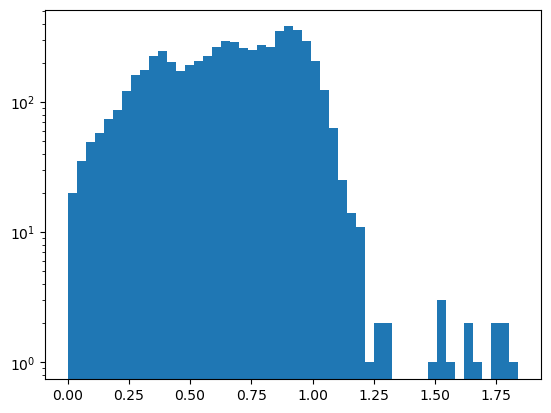

In [60]:
#plt.hist(bbb_scaled[:,10], bins=50)
#plt.yscale('log')
#plt.show()

In [17]:
#print(bbb_scaled.shape)

(7296, 12)


In [11]:
'''nmincluster = 4
nminsamples = 2
eps = 0.17

bbb_scaled = np.vstack((hit_batches_scaled[2], stg_params_scaled))
bbb_unscaled = np.vstack((hit_batches_unscaled[0], stg_params_unscaled))
#print(bbb.shape)
#bbb_scaled, bbb_unscaled = preprocess(bbb)

#plt.hist(bbb_scaled[0], bins=50)
#plt.yscale('log')
#plt.show()

print(bbb_scaled.shape)
print(bbb_unscaled.shape)

labels_list = batch_hdbscan(bbb_scaled, nmincluster, nminsamples, eps)

print(np.unique(labels_list))
print(labels_list[-10:])
print(len(np.where(labels_list==-1)[0]))
print(len(np.where(labels_list==-1)[0])/len(labels_list))
print(mode(labels_list)[1]/len(labels_list))'''

(5012, 12)
(5012, 12)
[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121]
[ 2 -1 -1  2  2  2  2 -1 -1  2]
1490
0.29728651237031123
0.4748603351955307


In [30]:
#for i in range(len(hit_batches_scaled)):

nmincluster = 4
nminsamples = 2
eps = 0.17

cluster_counts = []
dat_list_for_hit_deletion = np.empty((0, 2))
largest_cluster_sizes = []

for i in range(len(hit_batches_scaled)):
    print('-----')
    #bbb_scaled = hit_batches_scaled[i]
    bbb_scaled = np.vstack((hit_batches_scaled[i], stg_params_scaled))
    labels_list = batch_hdbscan(bbb_scaled, nmincluster, nminsamples, eps)
    dat_freq_obj = np.transpose(np.array([hit_batches_unscaled[i][:,0], dat_batches[i]], dtype='object'))
    non_anom_labels = np.array(list(set(np.unique(labels_list))-set(np.unique(np.concatenate((labels_list[-10:], [-1]))))))
    #print(non_anom_labels)
    mask = np.isin(labels_list[:-10], non_anom_labels)
    dat_freq_obj = dat_freq_obj[mask]

    #print(len(np.where(labels_list==-1)[0]))
    print(labels_list[-10:])
    #print(mask)
    #print(len(dat_freq_obj))
    print(f'{len(np.unique(labels_list))} unique clusters')
    print(f'{round(100*len(np.where(labels_list==-1)[0])/len(labels_list), 3)}% anomalies')
    print(f'{round(100*mode(labels_list)[1]/len(labels_list), 3)}% in largest cluster')

    cluster_counts.append(len(np.unique(labels_list)))
    largest_cluster_sizes.append(100*mode(labels_list)[1]/len(labels_list))
    dat_list_for_hit_deletion = np.concatenate((dat_list_for_hit_deletion, dat_freq_obj))

-----
[ 3 -1 -1  3  3  3  3 -1 -1  3]
125 unique clusters
29.01% anomalies
43.895% in largest cluster
-----
[0 0 1 0 0 0 0 0 1 0]
5 unique clusters
0.559% anomalies
98.504% in largest cluster
-----
[ 1 -1 -1  1  1  1  1 -1 -1  1]
124 unique clusters
30.507% anomalies
47.127% in largest cluster
-----
[ 0  0 -1  0  0  0  0  0  1  0]
6 unique clusters
1.057% anomalies
98.065% in largest cluster
-----
[0 0 0 0 0 0 0 0 0 0]
2 unique clusters
0.0% anomalies
99.9% in largest cluster
-----
[ 2 -1 -1  2  2  2  2 -1 -1  2]
131 unique clusters
29.29% anomalies
42.358% in largest cluster
-----
[0 0 0 0 0 0 0 0 0 0]
2 unique clusters
0.0% anomalies
99.9% in largest cluster
-----
[ 1 -1 -1  1  1  1  1 -1 -1  1]
114 unique clusters
29.689% anomalies
50.439% in largest cluster
-----
[ 0 -1 -1  0  0  0  0  0 -1  0]
116 unique clusters
29.769% anomalies
48.723% in largest cluster
-----
[ 1 -1 -1  1  1  1  1 -1 -1  1]
133 unique clusters
29.529% anomalies
44.054% in largest cluster
-----
[0 0 0 0 0 0 0 0

In [22]:
process = psutil.Process()

print(process.memory_info().rss)

2445598720


In [31]:
np.save('/datax/scratch/benjb/C23_L_dat_list_for_hit_deletion.npy', dat_list_for_hit_deletion)

In [32]:
print(dat_list_for_hit_deletion.shape)

(1049546, 2)


In [37]:
print(dat_list_for_hit_deletion[0][0])
print(dat_list_for_hit_deletion[0][1])

1573.938224
/home/obs/turboseti/AGBT20B_999_05/blc33_blp03/blc33_guppi_59077_09608_HIP59493_0081.rawspec.0000/blc33_guppi_59077_09608_HIP59493_0081.rawspec.0000.dat


In [38]:
import os

for i in range(len(dat_list_for_hit_deletion)):
    freq = dat_list_for_hit_deletion[i][0]
    dat_path = '/datax/scratch/benjb/C23_L_dats/'+os.path.basename(dat_list_for_hit_deletion[i][1])
    if i%10000 == 0:
        print(f'Removing hit at frequency {freq} from {dat_path}')

    bytes_available = psutil.virtual_memory()[1]
    if bytes_available <= 32e9:
        print(f'Memory dangerously low: {bytes_available} bytes remaining. Breaking ...')
        break

    lines = []
    for line in open(dat_path):
        if not str(freq) in line:
            lines.append(line)

    with open(dat_path, 'w') as file:
        file.writelines(lines)
        file.close()

Removing hit at frequency 1573.938224 from /datax/scratch/benjb/C23_L_dats/blc33_guppi_59077_09608_HIP59493_0081.rawspec.0000.dat
Removing hit at frequency 1546.806995 from /datax/scratch/benjb/C23_L_dats/blc03_guppi_59427_01327_NGC4564_0044.rawspec.0000.dat
Removing hit at frequency 1373.597749 from /datax/scratch/benjb/C23_L_dats/blc04_guppi_59405_69824_HIP59923_0105.rawspec.0000.dat
Removing hit at frequency 1546.707479 from /datax/scratch/benjb/C23_L_dats/spliced_blc5051525354555657_guppi_58892_53836_HIP74072_0083.rawspec.0000.dat
Removing hit at frequency 1381.52286 from /datax/scratch/benjb/C23_L_dats/blc14_guppi_59886_05001_NGC720_0056.rawspec.0000.dat
Removing hit at frequency 1598.792468 from /datax/scratch/benjb/C23_L_dats/blc73_guppi_58832_13933_HIP5599_0050.gpuspec.0000.dat
Removing hit at frequency 1378.459426 from /datax/scratch/benjb/C23_L_dats/blc04_guppi_59405_57552_NGC1407_0068.rawspec.0000.dat
Removing hit at frequency 1535.427843 from /datax/scratch/benjb/C23_L_dats

0.6521739130434783


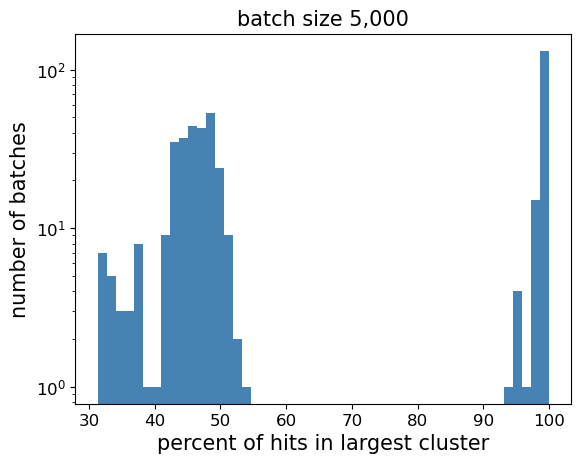

In [24]:
print(1-len(np.where(np.array(largest_cluster_sizes)>90)[0])/len(largest_cluster_sizes))
plt.hist(largest_cluster_sizes, color='steelblue', bins=50)
plt.yscale('log')
plt.xlabel('percent of hits in largest cluster', size=15)
plt.ylabel('number of batches', size=15)
plt.title('batch size 5,000', size=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('/datax/scratch/benjb/C23_L_hyperparameter_selection_lg_cluster_pct__5k_4_2_0.17.pdf', bbox_inches='tight')
plt.show()

In [170]:
#for i in range(len(hit_batches_scaled)):
#for i in range(20):
#    print('-----')
#    avg_variances = []
#    for j in [3, 4, 5, 6, 7, 8]:
#        #bbb_scaled = np.vstack((hit_batches_scaled[i], stg_params_scaled[:6]))
 #       bbb_scaled = hit_batches_scaled[i]
 #       nmincluster = j
 #       nminsamples = 2
 #       eps = 0 
#        cluster_variances = []
#        labels_list = batch_hdbscan(bbb_scaled, nmincluster, nminsamples, eps)
#        for k in np.unique(labels_list[1:]):
#            cluster = bbb_scaled[np.where(labels_list==k)[0]]
#            #print(cluster.shape)
#            variance = np.std(cluster)
#            cluster_variances.append(variance)
#        avg_variances.append(np.mean(cluster_variances))
#    best_nmincluster = np.argmin(avg_variances) + 3
#    print(best_nmincluster)
#    labels_list = batch_hdbscan(bbb_scaled, best_nmincluster, nminsamples, eps)
#
#    #print(len(np.where(labels_list==-1)[0]))
#    print(labels_list[-5:])
#    print(f'{round(100*len(np.where(labels_list==-1)[0])/len(labels_list), 3)}% anomalies')
#    print(f'{round(100*mode(labels_list)[1]/len(labels_list), 3)}% in largest cluster')

-----
5
[108  -1  -1  -1  -1]
50.468% anomalies
50.468% in largest cluster
-----
5
[100  -1 126  -1   9]
46.616% anomalies
46.616% in largest cluster
-----
3
[ -1  29  -1 305 131]
44.359% anomalies
44.359% in largest cluster
-----
4
[ -1  -1 197  -1  -1]
50.128% anomalies
50.128% in largest cluster
-----
3
[ -1  -1  -1  -1 351]
42.593% anomalies
42.593% in largest cluster
-----
3
[0 0 0 0 0]
0.021% anomalies
99.872% in largest cluster
-----
3
[ -1 304 419  -1  76]
46.743% anomalies
46.743% in largest cluster
-----
3
[ 15 297  70  -1  -1]
41.975% anomalies
41.975% in largest cluster
-----
4
[34 -1 -1 -1 -1]
49.489% anomalies
49.489% in largest cluster
-----
4
[ -1 168  -1  59 148]
48.127% anomalies
48.127% in largest cluster
-----
3
[247 199 311  17  57]
43.21% anomalies
43.21% in largest cluster
-----
3
[165  -1  62 479  -1]
47.765% anomalies
47.765% in largest cluster
-----
3
[396 264  -1 371  -1]
49.021% anomalies
49.021% in largest cluster
-----
3
[190 114  -1 141  60]
43.252% anoma

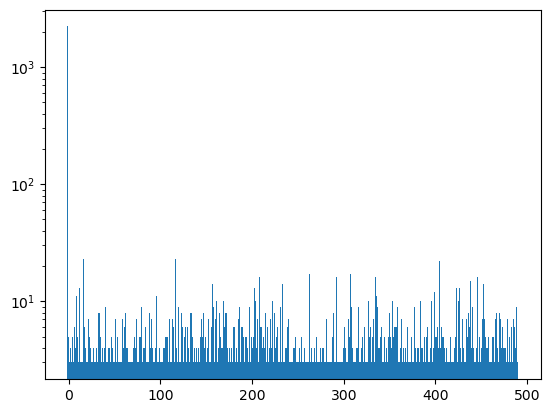

In [168]:
#plt.hist(labels_list, bins=len(np.unique(labels_list)), range=[-1.5, np.max(np.unique(labels_list))+0.5])
#plt.yscale('log')
#plt.show()

[-1  0  1]
Scattering ...
Refining ...


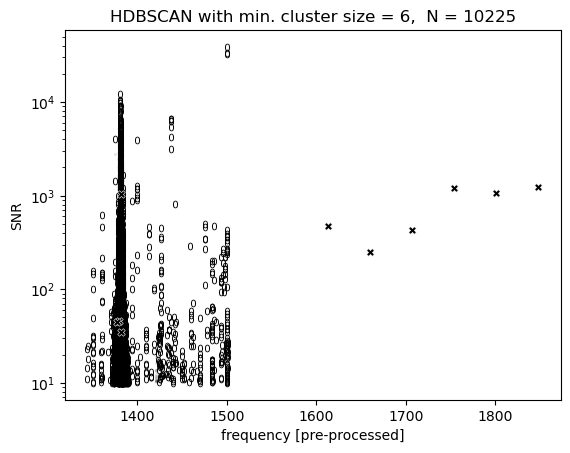

In [146]:
""" col_idx_x = 0
col_idx_y = 2

df = pd.DataFrame(bbb_scaled,
                   columns=['frequency [MHz]', 
                            'drift rate [Hz/s]', 
                            'log10 SNR', 
                            'skewness', 
                            'log10 kurtosis', 
                            'Sarle\'s coefficient', 
                            'correlation coefficient [kurtosis vs. log(bandwidth)]', 
                            'log10 turning-point bandwidth [Hz]', 
                            'temporal skewness', 
                            'log10 time-series standard deviation', 
                            'log10 power-spectrum standard deviation',
                            'signal bandwidth [Hz]'])

dfu = pd.DataFrame(bbb_unscaled,
                   columns=['frequency [pre-processed]', 
                            'drift rate [pre-processed]', 
                            'SNR', 
                            'spectral skewness', 
                            'spectral kurtosis', 
                            'Sarle\'s coefficient', 
                            'correlation coefficient [kurtosis vs. log(bandwidth)]', 
                            'turning-point bandwidth [Hz]', 
                            'temporal skewness', 
                            'time-series standard deviation', 
                            'power-spectrum standard deviation',
                            'signal bandwidth [Hz]'])

labels = np.unique(labels_list)
print(labels)

x_param = dfu.columns[col_idx_x]
y_param = dfu.columns[col_idx_y]

x = dfu[x_param].values
y = dfu[y_param].values

colors = cm.nipy_spectral(np.linspace(0, 1, len(labels)-1))

print('Scattering ...')
for l in labels[::-1]:
    idxs = np.where(labels_list == l)[0]
    if l == -1.:
        plt.scatter(x[idxs], y[idxs], color='k', s=5, alpha=0.1, linewidths=0, label=f'n={len(idxs)}')
    else:
        plt.scatter(x[idxs], y[idxs], marker=f'${l}$', color=colors[l], s=30, linewidths=0, label=f'n={len(idxs)}')

#other_idxs = np.array([3068, 3069, 3070])
plt.scatter(x[-10:], y[-10:], color='k', edgecolors='w', linewidths=0.4, s=30, marker='X')

print('Refining ...')

if 'log10' in df.columns[col_idx_x]:
    plt.xscale('log')
else:
    plt.xscale('linear')
if 'log10' in df.columns[col_idx_y]:
    plt.yscale('log')
else:
    plt.yscale('linear')

plt.xlabel(x_param)
plt.ylabel(y_param)
plt.title(f'HDBSCAN with min. cluster size = {nmincluster},  N = {len(x)}')

#leg = plt.legend(fontsize=8)
#for lh in leg.legendHandles: 
#    lh.set_alpha(1)
#    lh.set_sizes([30])
#plt.xscale('log')
#plt.yscale('log')

#plt.savefig(f'HDBSCAN_clustering_{col_idx_x}_{col_idx_y}.pdf')

plt.show() """